In [1]:
from collections import defaultdict, deque
from typing import Any

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import supervision as sv
from numpy.typing import ArrayLike, NDArray
from ultralytics import YOLO

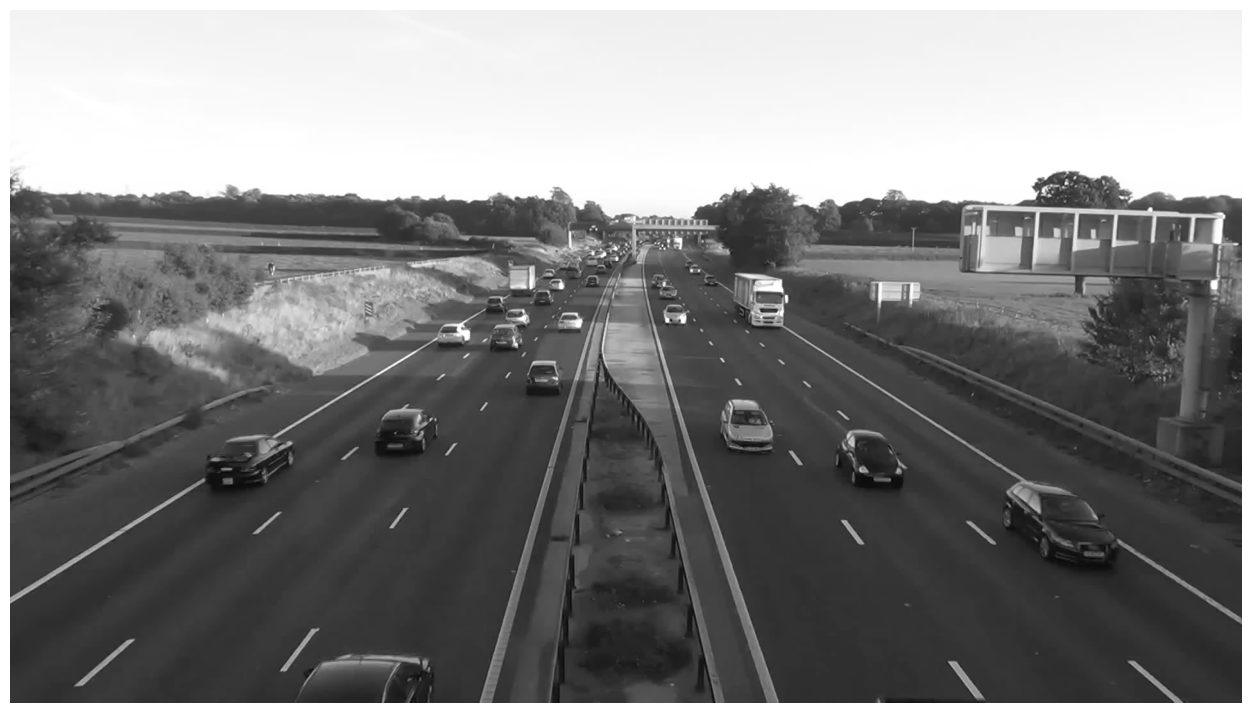

In [2]:
cap = cv.VideoCapture("m6-motorway.mp4")
ret, frame = cap.read()
cap.release()

frame = cv.cvtColor(cv.cvtColor(frame, cv.COLOR_BGR2GRAY), cv.COLOR_GRAY2RGB)

plt.figure(figsize=(16, 9))
plt.imshow(frame)
plt.axis("off")
plt.show()

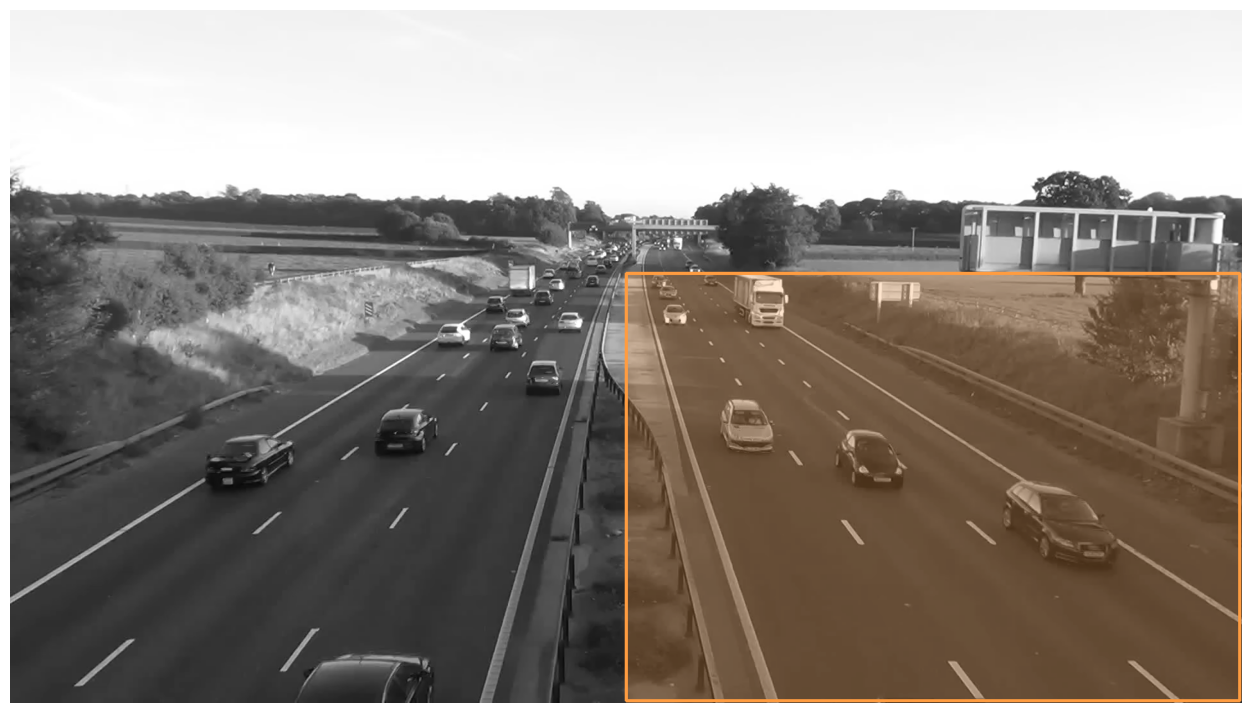

In [5]:
x1, y1, x2, y2 = 960, 410, 1920, 1080

thickness = 4
width = x2 - x1 - thickness
height = y2 - y1 - thickness
color = sv.Color(255, 156, 64)
rect = sv.Rect(x1, y1, width, height)

rect_frame = frame.copy()
sv.draw_rectangle(rect_frame, rect, color, thickness)
sv.draw_filled_rectangle(rect_frame, rect, color, 0.25)

plt.figure(figsize=(16, 9))
plt.imshow(cv.cvtColor(rect_frame, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

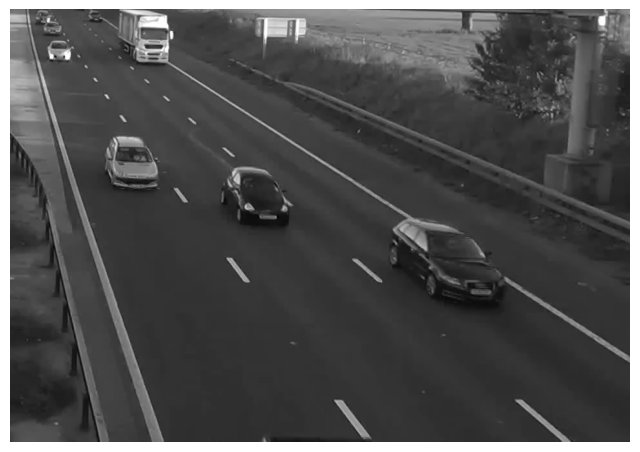

In [6]:
crop = sv.crop_image(frame, (x1, y1, x2, y2))
crop_imgsz = crop.shape[:2]  # height, width

plt.figure(figsize=(8, 8))
plt.imshow(crop)
plt.axis("off")
plt.show()

In [7]:
class PointMarker:
    def __init__(self, window: str = "Image") -> None:
        self._window = window
        self._points: list[tuple[int, int]] = list()

    def __call__(self, image: NDArray) -> list[tuple[int, int]]:
        return self.mark(image)

    @property
    def points(self) -> list[tuple[int, int]]:
        return self._points

    def mark(self, image: NDArray) -> list[tuple[int, int]]:
        image = image.copy()
        cv.namedWindow(self._window, cv.WINDOW_NORMAL)
        cv.setMouseCallback(self._window, self._record_point, param=image)

        while True:
            cv.imshow(self._window, image)
            if cv.waitKey(1) == ord("q"):
                break

        cv.destroyAllWindows()
        return self._points

    def _record_point(self, event: int, x: int, y: int, flags: int, image: Any | None) -> None:
        if event == cv.EVENT_LBUTTONDOWN:
            self._points.append((x, y))
            if image is not None:
                self._draw_point(image, (x, y))

    def _draw_point(self, image: NDArray, point: tuple[int, int]) -> None:
        cv.drawMarker(image, point, (0, 123, 255), cv.MARKER_CROSS, 20, 4, cv.LINE_AA)

In [118]:
# marker = PointMarker()
# image_pts = marker(cropped)

In [8]:
class Cam2WorldMapper:
    def __init__(self) -> None:
        self.M: NDArray | None = None

    def __call__(self, image_pts: ArrayLike) -> NDArray:
        return self.map(image_pts)

    def estimate_perspective_transform(self, image_pts: ArrayLike, world_pts: ArrayLike) -> NDArray:
        image_pts = np.asarray(image_pts, dtype=np.float32).reshape(-1, 1, 2)
        world_pts = np.asarray(world_pts, dtype=np.float32).reshape(-1, 1, 2)
        self.M = cv.getPerspectiveTransform(image_pts, world_pts)
        return self.M

    def map(self, image_pts: ArrayLike) -> NDArray:
        if self.M is None:
            raise ValueError("Perspective transform not estimated")
        image_pts = np.asarray(image_pts, dtype=np.float32).reshape(-1, 1, 2)
        return cv.perspectiveTransform(image_pts, self.M).reshape(-1, 2)

In [9]:
image_pts = [(30, 10), (180, 10), (780, 310), (110, 310)]
world_pts = [(0, 0), (12, 0), (12, 130), (0, 130)]

mapper = Cam2WorldMapper()
mapper.estimate_perspective_transform(image_pts, world_pts)
mapper(image_pts)

array([[          0,           0],
       [         12,  4.0848e-14],
       [         12,         130],
       [ 3.5174e-16,         130]], dtype=float32)

In [13]:
source = "m6-motorway.mp4"
output = "m6-motorway-annotated.mp4"

video_info = sv.VideoInfo.from_video_path(source)
thickness = sv.calculate_optimal_line_thickness((video_info.width, video_info.height))
text_scale = sv.calculate_optimal_text_scale((video_info.width, video_info.height))

bbox_annotator = sv.BoxAnnotator(
    color=sv.ColorPalette.DEFAULT,
    thickness=2,
    color_lookup=sv.ColorLookup.TRACK,
)
trace_annotator = sv.TraceAnnotator(
    color=sv.ColorPalette.DEFAULT,
    position=sv.Position.CENTER,
    thickness=2,
    trace_length=video_info.fps,
    color_lookup=sv.ColorLookup.TRACK,
)
label_annotator = sv.RichLabelAnnotator(
    color=sv.ColorPalette.DEFAULT,
    border_radius=2,
    font_size=16,
    color_lookup=sv.ColorLookup.TRACK,
    text_padding=5,
)

crop_h, crop_w = crop_imgsz
polygon = np.array([(0, 100), (crop_w, 100), (crop_w, 500), (0, 525)])

zone = sv.PolygonZone(polygon, [sv.Position.BOTTOM_RIGHT])


yolo = YOLO("yolo11m.pt", task="detect")
classes = [2, 5, 7]  # Car, Bus, Truck
conf = 0.5  # Detetion confidence threshold

cv.namedWindow("frame", cv.WINDOW_NORMAL)
tracks = defaultdict(lambda: deque(maxlen=video_info.fps))

with sv.VideoSink(output, video_info=video_info) as sink:
    for frame in sv.get_video_frames_generator(source, end=600):
        frame = cv.cvtColor(cv.cvtColor(frame, cv.COLOR_BGR2GRAY), cv.COLOR_GRAY2RGB)

        crop = sv.crop_image(frame, (x1, y1, x2, y2))
        result = yolo.track(crop, classes=classes, conf=conf, imgsz=crop_imgsz, persist=True, verbose=False)
        detection = sv.Detections.from_ultralytics(result[0])

        mask = zone.trigger(detections=detection)
        detection = detection[mask]

        speeds = {}
        for trace_id in np.unique(trace_annotator.trace.tracker_id):
            trace = trace_annotator.trace.get(trace_id)
            if len(trace) > 1:
                dx, dy = np.abs(np.diff(mapper(trace), axis=0)).mean(axis=0)
                ds = np.linalg.norm((dx, dy))
                dt = 1 / video_info.fps
                speeds[trace_id] = 3.6 * ds / dt

        speeds = list(speeds.get(track_id, 0) for track_id in detection.tracker_id)  # type: ignore
        trace_ids = detection.tracker_id  # type: ignore

        labels = list(f"#{idx}: {speed:.0f} km/h" for idx, speed in zip(trace_ids, speeds))  # type: ignore

        crop = bbox_annotator.annotate(crop, detection)  # type: ignore
        crop = trace_annotator.annotate(crop, detection)  # type: ignore
        crop = label_annotator.annotate(crop, detection, labels=labels)  # type: ignore

        sink.write_frame(frame)
        cv.imshow("frame", frame)

        if cv.waitKey(1) == ord("q"):
            break

cv.destroyAllWindows()

WARNING  imgsz=[670, 960] must be multiple of max stride 32, updating to [672, 960]
WARNING  imgsz=[670, 960] must be multiple of max stride 32, updating to [672, 960]
WARNING  imgsz=[670, 960] must be multiple of max stride 32, updating to [672, 960]
WARNING  imgsz=[670, 960] must be multiple of max stride 32, updating to [672, 960]
WARNING  imgsz=[670, 960] must be multiple of max stride 32, updating to [672, 960]
WARNING  imgsz=[670, 960] must be multiple of max stride 32, updating to [672, 960]
WARNING  imgsz=[670, 960] must be multiple of max stride 32, updating to [672, 960]
WARNING  imgsz=[670, 960] must be multiple of max stride 32, updating to [672, 960]
WARNING  imgsz=[670, 960] must be multiple of max stride 32, updating to [672, 960]
WARNING  imgsz=[670, 960] must be multiple of max stride 32, updating to [672, 960]
WARNING  imgsz=[670, 960] must be multiple of max stride 32, updating to [672, 960]
WARNING  imgsz=[670, 960] must be multiple of max stride 32, updating to [67